In [1]:
!mkdir p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d crawford/emnist

100% 1.24G/1.24G [00:37<00:00, 38.5MB/s]
100% 1.24G/1.24G [00:37<00:00, 35.5MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/emnist.zip','r')
zip_ref.extractall('/content/emnist/')
zip_ref.close()

In [4]:
#import required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,Input
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [5]:
def convert_image(image):
    rotated_image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    flipped_image = cv2.flip(rotated_image, 1)
    return flipped_image

In [6]:
def data_ingestion():
  '''
  ingesting the data of mnist from pip

  Args:
    Null
  Returns:
    train_data,
    test_data
  '''
  train_images_file = "/content/emnist/emnist_source_files/emnist-digits-train-images-idx3-ubyte"
  train_labels_file = "/content/emnist/emnist_source_files/emnist-digits-train-labels-idx1-ubyte"
  test_images_file = "/content/emnist/emnist_source_files/emnist-digits-test-images-idx3-ubyte"
  test_labels_file = "/content/emnist/emnist_source_files/emnist-digits-test-labels-idx1-ubyte"

  with open(train_images_file, 'rb') as f:
      train_images = np.frombuffer(f.read(), dtype=np.uint8, offset=16).reshape(-1,28,28,1)

  with open(train_labels_file, 'rb') as f:
      train_labels = np.frombuffer(f.read(), dtype=np.uint8, offset=8)

  with open(test_images_file, 'rb') as f:
      test_images = np.frombuffer(f.read(), dtype=np.uint8, offset=16).reshape(-1,28,28,1)

  with open(test_labels_file, 'rb') as f:
      test_labels = np.frombuffer(f.read(), dtype=np.uint8, offset=8)

  train_images = np.array([convert_image(img) for img in train_images])
  test_images = np.array([convert_image(img) for img in test_images])

  return train_images,train_labels,test_images,test_labels

In [7]:
train_images, train_labels, test_images, test_labels = data_ingestion()

In [8]:
def data_visualization(train_images,train_labels,test_labels,num_samples=20):

  '''
  function where emnist data is visualized
  '''
  print("shape of image",train_images[0].shape)
  print("No of train_samples",len(train_labels))
  print("No of test_samples", len(test_labels))
  print("Number of labels in the dataset is :", len(np.unique(train_labels)))

  plt.figure(figsize=(15, 5))
  for i in range(num_samples):
      plt.subplot(2, num_samples // 2, i + 1)  # Adjust subplot arrangement
      plt.imshow(train_images[i], cmap='gray')
      plt.title(train_labels[i])
      plt.axis('off')
  plt.show()

  plt.figure(figsize=(10,8))
  sns.countplot(x=train_labels)
  plt.title("Distribution of letters in dataset")
  plt.show()
  return

shape of image (28, 28)
No of train_samples 240000
No of test_samples 40000
Number of labels in the dataset is : 10


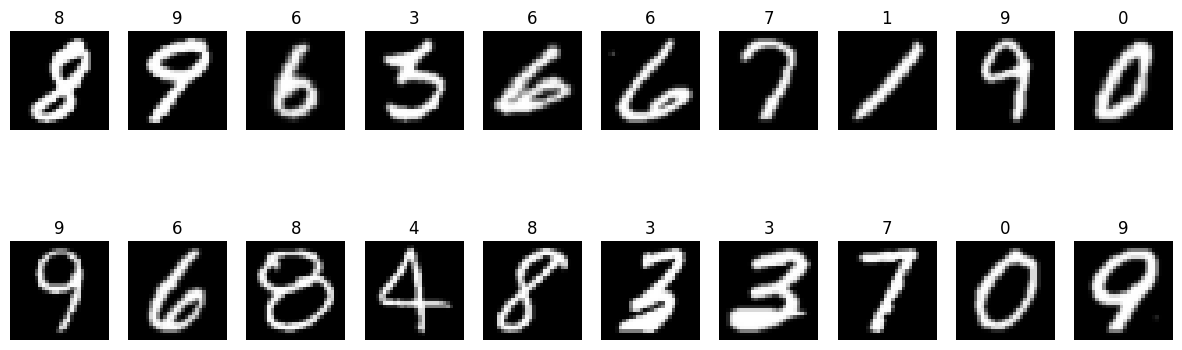

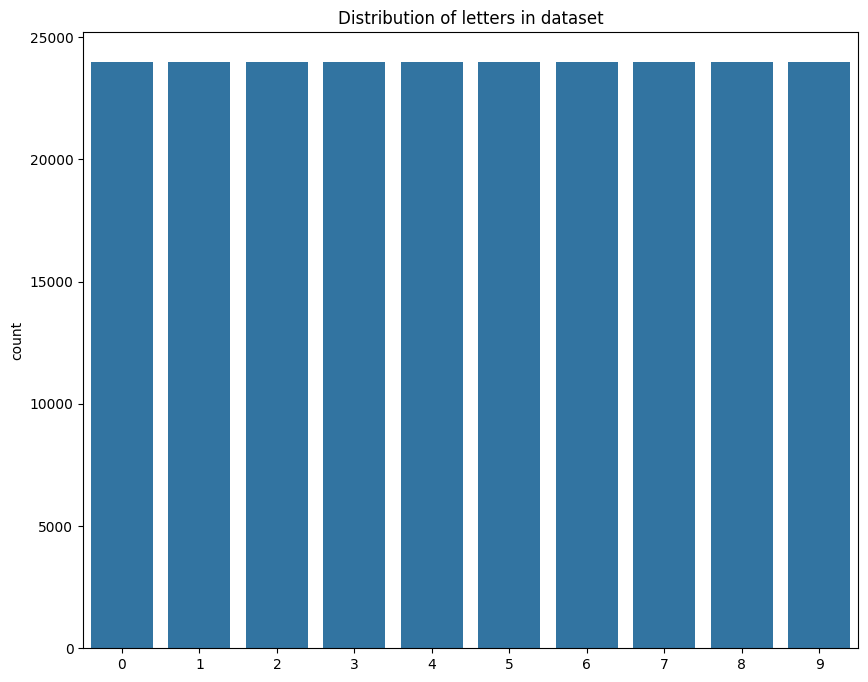

In [9]:
data_visualization(train_images,train_labels,test_labels)

In [11]:
def data_preprocessing(train_images,test_images,train_labels,test_labels):

  '''
  function to preprocess the images ready to be used for training
  '''

  train_images = train_images / 255.0
  test_images = test_images / 255.0

  train_labels = to_categorical(train_labels)
  test_labels = to_categorical(test_labels)

  return train_images,test_images,train_labels,test_labels

In [12]:
train_images,test_images,train_labels,test_labels = data_preprocessing(train_images,test_images,train_labels,test_labels)

In [13]:
def data_splitting(train_images,train_labels):
  x_train,y_train,x_test,y_test = train_test_split(train_images,train_labels,random_state=42,test_size=0.2)
  return x_train,y_train,x_test,y_test

In [14]:
x_train,x_test,y_train,y_test = data_splitting(train_images,train_labels)

In [15]:
def model_architecture():

  model = Sequential()
  model.add(Input(shape=(28, 28, 1)))
  model.add(Conv2D(128, kernel_size=(3, 3), padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))
  model.add(Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))
  model.add(Flatten())
  model.add(Dense(64, activation="relu"))
  model.add(Dropout(0.3))
  model.add(Dense(10, activation="softmax"))

  return model

In [16]:
model = model_architecture()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 128)       1280      
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 64)                2

In [17]:
def training_model(model,X_train,y_train,X_test,y_test):

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
  return history

In [18]:
history = training_model(model,x_train,y_train,x_test,y_test)

Epoch 1/10
6000/6000 [==============================] - 47s 7ms/step - loss: 0.1086 - accuracy: 0.9681 - val_loss: 0.0371 - val_accuracy: 0.9898
Epoch 2/10
6000/6000 [==============================] - 39s 6ms/step - loss: 0.0444 - accuracy: 0.9878 - val_loss: 0.0361 - val_accuracy: 0.9907
Epoch 3/10
6000/6000 [==============================] - 44s 7ms/step - loss: 0.0320 - accuracy: 0.9912 - val_loss: 0.0318 - val_accuracy: 0.9924
Epoch 4/10
6000/6000 [==============================] - 43s 7ms/step - loss: 0.0261 - accuracy: 0.9927 - val_loss: 0.0310 - val_accuracy: 0.9929
Epoch 5/10
6000/6000 [==============================] - 38s 6ms/step - loss: 0.0222 - accuracy: 0.9937 - val_loss: 0.0278 - val_accuracy: 0.9937
Epoch 6/10
6000/6000 [==============================] - 37s 6ms/step - loss: 0.0195 - accuracy: 0.9945 - val_loss: 0.0295 - val_accuracy: 0.9936
Epoch 7/10
6000/6000 [==============================] - 36s 6ms/step - loss: 0.0174 - accuracy: 0.9952 - val_loss: 0.0325 - val_ac

In [19]:
def plot_history(history):
    plt.figure(figsize=(12, 6))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

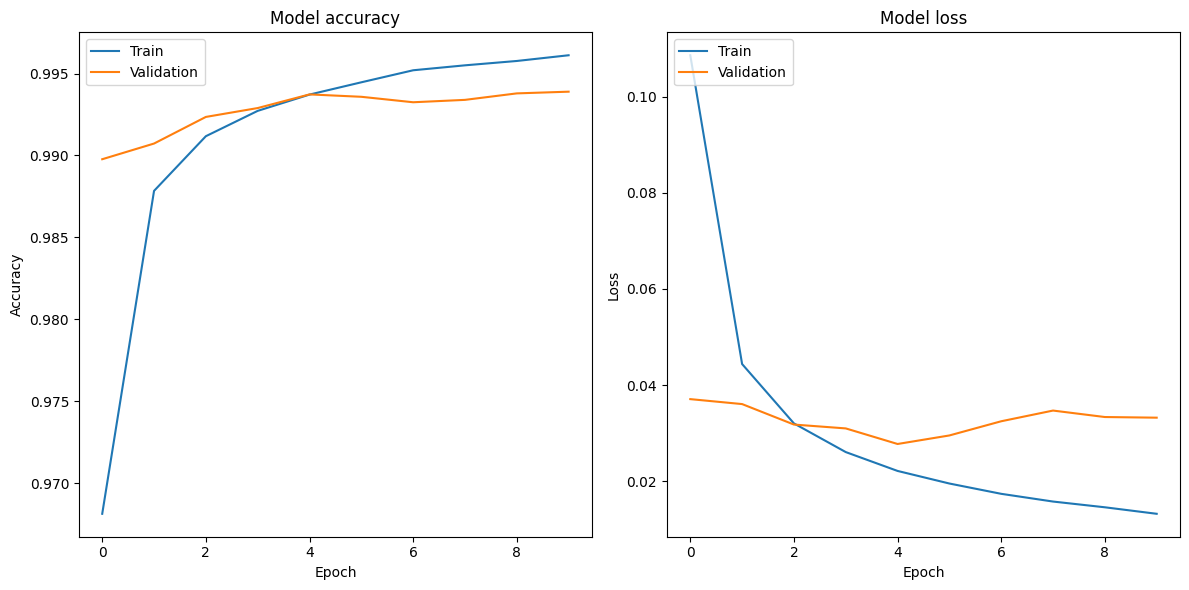

In [20]:
plot_history(history)

In [21]:
def model_evaluation(model,X_test,y_test):
  test_loss, test_acc = model.evaluate(X_test, y_test)
  print(f'Test accuracy: {test_acc}')
  return

In [22]:
model_evaluation(model,test_images,test_labels)

1250/1250 [==============================] - 4s 3ms/step - loss: 0.0223 - accuracy: 0.9953
Test accuracy: 0.9953250288963318


In [23]:
def testing_model(model,X_train):
  arr = [0,1,2,3,4,5,6,7,8,9]
  # Change the index to use a different image for prediction
  image_index = 1178
  img = X_train[image_index]
  img = np.expand_dims(img, axis=0)  # Add batch dimension

  # Make prediction
  prediction = model.predict(img)
  predicted_label = np.argmax(prediction)

  plt.imshow(X_train[image_index], cmap="gray")
  plt.title(f"Prediction: {arr[predicted_label]}")
  plt.axis('off')
  plt.show()

1/1 [==============================] - 0s 319ms/step


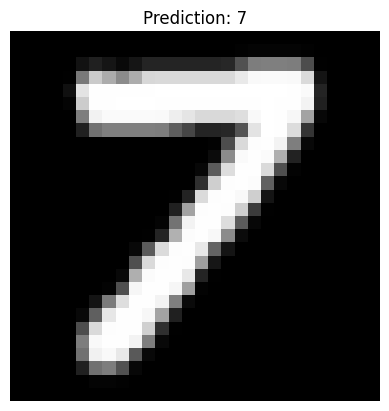

In [24]:
testing_model(model,test_images)

In [25]:
model.save("digit_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
